In [2]:
%load_ext autoreload
%autoreload 2

from pddl_rl_robot.simulation.two_peg_one_disk_env import TwoPegOneRoundNut
from robosuite.environments.manipulation.manipulation_env import ManipulationEnv
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3 import PPO
from robosuite.wrappers import GymWrapper

import os
import numpy as np

[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python c:\Users\xiaoyicong\anaconda3\envs\robosuite_project\lib\site-packages\robosuite/scripts/setup_macros.py (macros.py:55)
[robosuite WARNING] Could not import robosuite_models. Some robots may not be available. If you want to use these robots, please install robosuite_models from source (https://github.com/ARISE-Initiative/robosuite_models) or through pip install. (__init__.py:30)
[robosuite WARNING] Could not load the mink-based whole-body IK. Make sure you install related import properly, otherwise you will not be able to use the default IK controller setting for GR1 robot. (__init__.py:40)


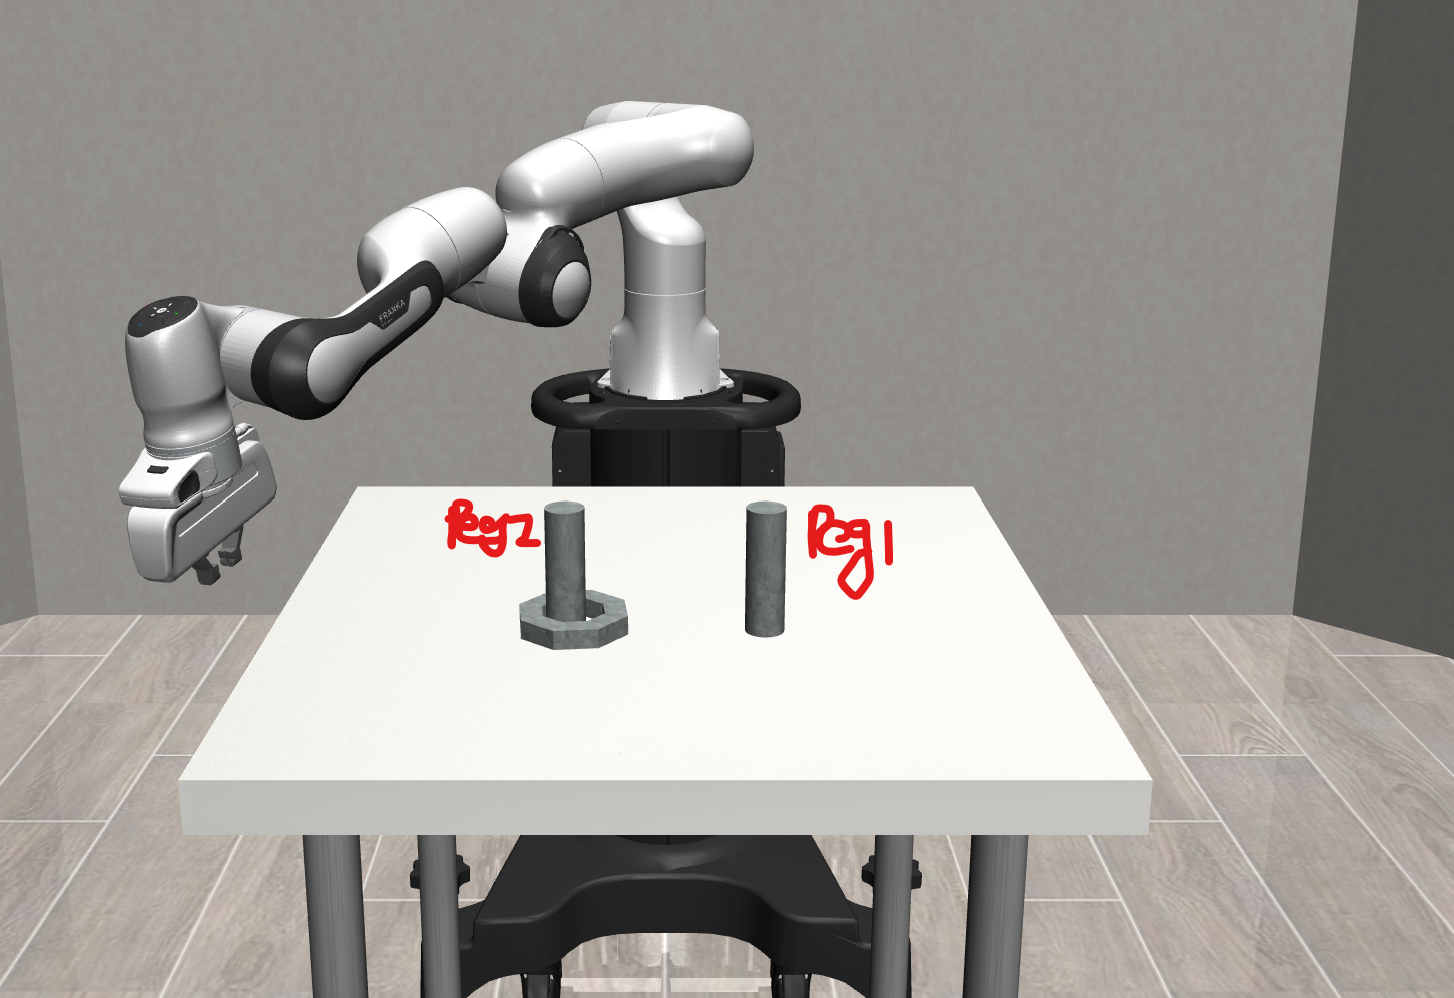

In [97]:
import mujoco

def set_body_position(data, model, body_name, pos_xyz, quat_wxyz):
    """
    Set the position of a specified body in the model.

    Args:
        data (MjData): The MuJoCo data object.
        model (MjModel): The MuJoCo model object.
        body_name (str): Name of the body to set position for.
        pos_xyz (np.ndarray | None): Target [x, y, z] position. If none, use original position.
        quat_wxyz (np.ndarray | None): Target [qw, qx, qy, qz] position. If none, use original position
    """
    
    body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, body_name)
    # Retrieve the joint type
    joint_id = model.body_jntadr[body_id]
    if joint_id >= 0 and model.jnt_type[joint_id] == 0:  # type 0 indicates a free joint
        # Set qpos for free joint: [pos_x, pos_y, pos_z, quat_w, quat_x, quat_y, quat_z]
        qpos_start = model.jnt_qposadr[joint_id]
        if isinstance(pos_xyz, np.ndarray):
            data.qpos[qpos_start : qpos_start + 3] = pos_xyz 
        if isinstance(quat_wxyz, np.ndarray): 
            data.qpos[qpos_start + 3 : qpos_start + 7] = quat_wxyz 
    else:
        raise ValueError(
            f"Body '{body_name}' does not have a free joint or is missing a joint."
        )

In [101]:
class MoveTrainingEnv(TwoPegOneRoundNut):
    """
    Modified version of task - place one round nut with two pegs in the environment.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _reset_internal(self):
        """
        Resets the environment by setting the robot's hand to hold the peg at a certain height.
        """
        ManipulationEnv._reset_internal(self)
        
        # Get the right peg's position
        right_peg_body_id = self.sim.model.body_name2id("peg2")  # Ensure "peg_right" is the correct name
        right_peg_pos = self.sim.data.body_xpos[right_peg_body_id].copy()

        # Set the minimum height to the height of the right peg
        min_height = right_peg_pos[2]
        max_height = min_height + 0.1

        # Define randomization range for x and y positions
        x_range = [0.07, 0.09]
        y_range = [-0.1, 0.1]

        # Get the nut's initial position
        nut_body_id = self.sim.model.body_name2id("RoundNut_main")
        nut_initial_pos = self.sim.data.body_xpos[nut_body_id].copy()
        print(f'Before entering the set function---- nut initially at : {nut_initial_pos}')
        
        # Create random xyz, move the peg to that location
        nut_new_x = np.random.uniform(x_range[0], x_range[1])  # Random x
        nut_new_y = np.random.uniform(y_range[0], y_range[1])  # Random y
        nut_new_z = np.random.uniform(min_height, max_height)  # Ensure height is above the peg

        nut_new_xyz = np.array([nut_new_x, nut_new_y, nut_new_z,])
        
        set_body_position(self.sim.data._data, self.sim.model._model, "RoundNut_main", nut_new_xyz, None)

        
        #print(self.sim.data.body_xpos[nut_body_id].copy())
        # # Get the robot’s gripper site
        # gripper_site_id = self.sim.model.site_name2id("gripper0_right_grip_site")  # Adjust based on robot model
        # gripper_pos = self.sim.data.site_xpos[gripper_site_id].copy()

        # # Align the gripper with the nut position
        # gripper_pos[:3] = nut_initial_pos[:3]

        # # Apply the new position to the robot’s joints
        # self.sim.data.set_joint_qpos("robot0_joint1", np.concatenate([gripper_pos, [1, 0, 0, 0]]))

        # # Close the gripper to hold the nut
        # self.sim.data.set_joint_qpos("robot0_gripper_joint", np.array([0.0, 0.0]))  # Adjust based on gripper type

        # # Forward simulation to apply changes
        # self.sim.forward()

    # Override the reward function (please design it such that it favors reaching the goal)
    def reward(self, action=None):
        return 10.0

In [102]:
# Create environment instance
env = MoveTrainingEnv(
    robots="Panda",  # Use Panda robot
    gripper_types="default",
    has_renderer=True,  # Enable visualization
    has_offscreen_renderer=False,  # Disable offscreen rendering
    use_camera_obs=False,  # Don't use camera observations
    reward_shaping=False,  # Enable reward shaping
)
#env = GymWrapper(env)

[robosuite INFO] Loading controller configuration from: c:\Users\xiaoyicong\anaconda3\envs\robosuite_project\lib\site-packages\robosuite\controllers\config\robots\default_panda.json (composite_controller_factory.py:121)


Before entering the set function---- nut initially at : [0. 0. 0.]


In [60]:
gripper_site_id = env.sim.model.site_name2id("gripper0_right_grip_site")  # Adjust based on robot model
gripper_pos = env.sim.data.site_xpos[gripper_site_id].copy()

gripper_pos

array([-0.01412205, -0.35219333,  0.8994367 ])

In [18]:
right_peg_body_id = env.sim.model.body_name2id("peg2")  # Ensure "peg_right" is the correct name
right_peg_pos = env.sim.data.body_xpos[right_peg_body_id].copy()

right_peg_pos

array([ 0.08, -0.1 ,  0.85])

In [18]:
env.sim.data.body_xpos[env.sim.model.joint_name2id("robot0_joint1")]

array([0., 0., 0.])

In [19]:
nut_id = env.sim.model.body_name2id("RoundNut_main")
nut_pos = env.sim.data.body_xpos[nut_id].copy()

nut_pos

array([0., 0., 0.])

In [103]:
# Configurations
total_timesteps = 1000
name_prefix = "ppo_panda_reach"

env = GymWrapper(env)

# Define the model
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=total_timesteps)
env.close()

[robosuite INFO] Loading controller configuration from: c:\Users\xiaoyicong\anaconda3\envs\robosuite_project\lib\site-packages\robosuite\controllers\config\robots\default_panda.json (composite_controller_factory.py:121)
[robosuite INFO] Loading controller configuration from: c:\Users\xiaoyicong\anaconda3\envs\robosuite_project\lib\site-packages\robosuite\controllers\config\robots\default_panda.json (composite_controller_factory.py:121)


Before entering the set function---- nut initially at : [0. 0. 0.]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Before entering the set function---- nut initially at : [0. 0. 0.]


KeyboardInterrupt: 